In [1]:
from __future__ import print_function
import sklearn
import sklearn.datasets
import sklearn.ensemble
import pandas as pd
import numpy as np
# import h2o
# from h2o.estimators.random_forest import H2ORandomForestEstimator
# from h2o.estimators.gbm import H2OGradientBoostingEstimator

np.random.seed(1)

import datetime as dt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle
import re

%matplotlib inline

In [2]:
input_dir = "../input/"

# Metadata

In [3]:
# usecols = ['ID', 'Label', 'Sub_type', 'PatientID']

usecols = ["sop_instance_uid", "patient_id", "study_instance_uid", "series_instance_uid", "filename"]

#train_metadata = pd.read_csv(input_dir + "stage_1_metadata.csv", usecols = usecols)

train_metadata = pd.read_csv(input_dir + "df_dicom_metadata_train.csv", usecols = usecols)
train_metadata["filename"] = train_metadata["filename"].apply(lambda x: x.split("/")[-1])
train_metadata["set"] = 1
print(train_metadata.shape)
train_metadata.head(3)

(674258, 6)


,sop_instance_uid,patient_id,study_instance_uid,series_instance_uid,filename,set
0,ID_ff816e9b6,ID_b14d854e,ID_c65a8f2f00,ID_79d2473b55,ID_ff816e9b6.dcm,1
1,ID_282a7f3cd,ID_79cf35b0,ID_9ee24d714d,ID_fe49a86511,ID_282a7f3cd.dcm,1
2,ID_f1c65b76e,ID_43dd2890,ID_43af13416f,ID_143018582f,ID_f1c65b76e.dcm,1


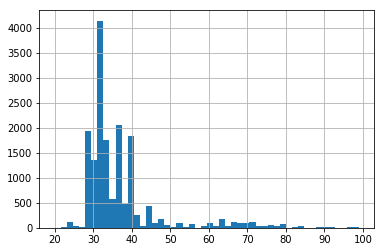

In [4]:
tmp = train_metadata["patient_id"].value_counts()
tmp[tmp<100].hist(bins=50);

In [5]:
test_metadata = pd.read_csv(input_dir + "df_dicom_metadata_test.csv", usecols = usecols)
test_metadata["filename"] = train_metadata["filename"].apply(lambda x: x.split("/")[-1])
test_metadata["set"] = 0
print(test_metadata.shape)
test_metadata.head(3)

(78545, 6)


,sop_instance_uid,patient_id,study_instance_uid,series_instance_uid,filename,set
0,ID_cec48be98,ID_02159492,ID_6d53e6b7a1,ID_8a81168925,ID_ff816e9b6.dcm,0
1,ID_24499006f,ID_d11a0081,ID_816f37dbe8,ID_d06566b389,ID_282a7f3cd.dcm,0
2,ID_398dc0001,ID_c4cc9737,ID_5f64ee7147,ID_ffa52dd6f4,ID_f1c65b76e.dcm,0


In [6]:
patient_id_train = set(train_metadata["patient_id"].unique())
patient_id_test = set(test_metadata["patient_id"].unique())
print(len(patient_id_train), len(patient_id_test))

17079 2144


In [7]:
patient_id_dup = patient_id_train.intersection(patient_id_test)
len(patient_id_dup)

285

# Label any

In [8]:
train_label = pd.read_csv(input_dir + "stage_1_train.csv", usecols = None)
print(train_label.shape)
train_label.head(3)

(4045572, 2)


,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0


In [9]:
train_label["sop_instance_uid"] = train_label["ID"].apply(lambda x: "ID_" + x.split("_")[1])
train_label["SubType"] = train_label["ID"].apply(lambda x: x.split("_")[2])
train_label.head(3)

,ID,Label,sop_instance_uid,SubType
0,ID_63eb1e259_epidural,0,ID_63eb1e259,epidural
1,ID_63eb1e259_intraparenchymal,0,ID_63eb1e259,intraparenchymal
2,ID_63eb1e259_intraventricular,0,ID_63eb1e259,intraventricular


In [10]:
print(train_label.shape[0])
train_label = train_label[train_label["SubType"] == "any"].copy()
print(train_label.shape[0])

4045572
674262


In [11]:
train_label.rename(columns={"Label": "any"}, inplace=True)
train_label.head(3)

,ID,any,sop_instance_uid,SubType
5,ID_63eb1e259_any,0,ID_63eb1e259,any
11,ID_2669954a7_any,0,ID_2669954a7,any
17,ID_52c9913b1_any,0,ID_52c9913b1,any


In [12]:
print(train_metadata.shape)
train_metadata = pd.merge(train_metadata, train_label[["sop_instance_uid", "any"]], on="sop_instance_uid")
print(train_metadata.shape)
train_metadata.head()

(674258, 6)
(674262, 7)


,sop_instance_uid,patient_id,study_instance_uid,series_instance_uid,filename,set,any
0,ID_ff816e9b6,ID_b14d854e,ID_c65a8f2f00,ID_79d2473b55,ID_ff816e9b6.dcm,1,0
1,ID_282a7f3cd,ID_79cf35b0,ID_9ee24d714d,ID_fe49a86511,ID_282a7f3cd.dcm,1,0
2,ID_f1c65b76e,ID_43dd2890,ID_43af13416f,ID_143018582f,ID_f1c65b76e.dcm,1,0
3,ID_3b59681d3,ID_174f992b,ID_31f18d004c,ID_def4bb5674,ID_3b59681d3.dcm,1,0
4,ID_f506d79aa,ID_5758a541,ID_0f7a5b14c1,ID_a701a416fc,ID_f506d79aa.dcm,1,0


# Number of studies per patients

In [13]:
train_metadata.head(3)

,sop_instance_uid,patient_id,study_instance_uid,series_instance_uid,filename,set,any
0,ID_ff816e9b6,ID_b14d854e,ID_c65a8f2f00,ID_79d2473b55,ID_ff816e9b6.dcm,1,0
1,ID_282a7f3cd,ID_79cf35b0,ID_9ee24d714d,ID_fe49a86511,ID_282a7f3cd.dcm,1,0
2,ID_f1c65b76e,ID_43dd2890,ID_43af13416f,ID_143018582f,ID_f1c65b76e.dcm,1,0


In [14]:
#df_studies = train_metadata[["patient_id", "study_instance_uid"]].drop_duplicates()

df_studies = train_metadata.groupby("patient_id")["study_instance_uid"].nunique()\
    .to_frame("nb_studies").reset_index()
print(train_metadata.shape, df_studies.shape)
df_studies.sort_values("nb_studies", ascending=False, inplace=True)
df_studies.head(3)

(674262, 7) (17079, 2)


,patient_id,nb_studies
2610,ID_268b38fe,15
13322,ID_c7b2c196,11
6270,ID_5e035492,11


# Splits

In [15]:
stacking_patients_train = set(df_studies[df_studies["nb_studies"] <= 2]["patient_id"])
stacking_patients_test = patient_id_test.difference(patient_id_dup)

print(df_studies.shape[0], len(stacking_patients_train), len(patient_id_test), len(stacking_patients_test))

17079 16646 2144 1859


In [16]:
train_metadata.shape[0], \
    train_metadata[train_metadata["patient_id"].isin(stacking_patients_train)].shape[0]

(674262, 611594)

In [17]:
test_metadata.shape[0], test_metadata[test_metadata["patient_id"].isin(stacking_patients_test)].shape[0]

(78545, 66894)

## Balancing

In [18]:
import random
seed = 2020
random.seed(seed)

df = train_metadata
df.head(3)

,sop_instance_uid,patient_id,study_instance_uid,series_instance_uid,filename,set,any
0,ID_ff816e9b6,ID_b14d854e,ID_c65a8f2f00,ID_79d2473b55,ID_ff816e9b6.dcm,1,0
1,ID_282a7f3cd,ID_79cf35b0,ID_9ee24d714d,ID_fe49a86511,ID_282a7f3cd.dcm,1,0
2,ID_f1c65b76e,ID_43dd2890,ID_43af13416f,ID_143018582f,ID_f1c65b76e.dcm,1,0


In [19]:
patients_pos = set(df[df["any"] == 1]["patient_id"].unique())
patients_pos_balance = patients_pos.intersection(stacking_patients_train)
print(len(patients_pos), len(patients_pos_balance))

patients_neg = stacking_patients_train - patients_pos_balance
patients_neg_balance = random.sample(patients_neg, len(patients_pos_balance))

stacking_patients_balance = patients_pos_balance.union(patients_neg_balance)

print(len(stacking_patients_train), len(stacking_patients_balance), \
      len(patients_pos_balance), len(patients_neg_balance))

6980 6704
16646 13408 6704 6704


## K-fold

In [20]:
# NOT stacking_patients_train
df_stacking_patients_train = pd.DataFrame(stacking_patients_balance)
df_stacking_patients_train.columns = ["patient_id"]
print(df_stacking_patients_train.shape)
df_stacking_patients_train.head(3)

(13408, 1)


,patient_id
0,ID_c9a4d5c0
1,ID_3dbf5080
2,ID_fef05960


In [21]:
from sklearn.model_selection import KFold

seed = 2020
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed) # StratifiedKFold

patient_id = np.array(list(stacking_patients_train))

df_stacking_patients_train["stacking_fold"] = -1

for fold, (train_index, valid_index) in enumerate(kf.split(patient_id)):
    valid_index = df_stacking_patients_train["patient_id"].isin(patient_id[valid_index])
    df_stacking_patients_train.loc[valid_index, "stacking_fold"] = fold
    
df_stacking_patients_train["stacking_fold"].value_counts()

0    2705
2    2688
3    2677
4    2670
1    2668
Name: stacking_fold, dtype: int64

In [22]:
df_stacking_patients_train.head(3)

,patient_id,stacking_fold
0,ID_c9a4d5c0,1
1,ID_3dbf5080,3
2,ID_fef05960,0


In [23]:
df_stacking_patients_test = pd.DataFrame(stacking_patients_test) 
df_stacking_patients_test.columns = ["patient_id"]
df_stacking_patients_test["stacking_fold"] = 5
print(df_stacking_patients_test.shape)
df_stacking_patients_test.head(3)

(1859, 2)


,patient_id,stacking_fold
0,ID_a5f31bd3,5
1,ID_21d74ff6,5
2,ID_ebb62360,5


## Merge train and test

In [24]:
df_stacking_patients = pd.concat([df_stacking_patients_train, df_stacking_patients_test], axis=0)
print(df_stacking_patients["stacking_fold"].value_counts())
df_stacking_patients.head(3)

0    2705
2    2688
3    2677
4    2670
1    2668
5    1859
Name: stacking_fold, dtype: int64


,patient_id,stacking_fold
0,ID_c9a4d5c0,1
1,ID_3dbf5080,3
2,ID_fef05960,0


## Save

In [25]:
output_filename = "../csv/patients_stacking_splits.csv"
df_stacking_patients.to_csv(output_filename, index=None)
output_filename, df_stacking_patients.shape

('../csv/patients_stacking_splits.csv', (15267, 2))

In [27]:
13408 + 1859, 1859 / 13408 

(15267, 0.1386485680190931)